In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Text(0.5,0,'time (sec)')

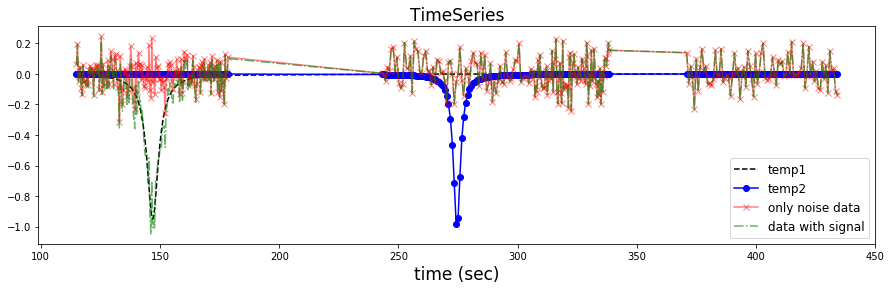

In [21]:
# times
delta_t = 0.4
n = 400
struct = "automix"
times = TimesSamples(initial_array=None, n=n, delta=delta_t, struct=struct)

# template
def eval(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm

t0 = min(times) + times.duration/2
tE = 0.8 
U0 = 3 #1.3 
fs = 24 #16.9
val = eval(U0, times[n//5], tE, fs, times) # temp1

tE = 0.5
U0 = 2.8
fs = 23
val2 = eval(U0, t0, tE, fs, times) # temp2

#use temp1 as data adding noise
noise_level = 0.1
noise = np.random.normal(0, noise_level, n)
data = val + noise

# define the timeSeries
temp1 = TimeSeries(val, times=times)
temp2 = TimeSeries(val2, times=times)
noise = TimeSeries(noise, times=times)
data = TimeSeries(data, times=times)

fig = plt.figure(figsize=(15, 4))
plt.plot(times, temp1, 'k--', label="temp1")
plt.plot(times, temp2, 'b-o', label="temp2")
plt.plot(times, noise, 'r-x', alpha=0.5, label="only noise data")
plt.plot(times, data, 'g-.', alpha=0.6, label="data with signal")
plt.legend(fontsize=12)
plt.title("TimeSeries", fontsize=17)
plt.xlabel("time (sec)", fontsize=17)


Text(0.5,0,'Frequency (Hz)')

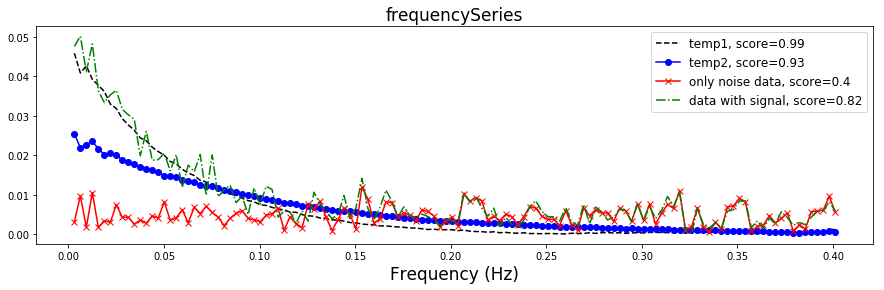

In [28]:
# define freq
gamma = 1
min_freq = 1/data.duration/gamma
max_freq = len(data) / 2 / data.duration 
max_freq = 0.4
freqs = FrequencySamples(input_time=times, 
                         minimum_frequency=min_freq, 
                         maximum_frequency=max_freq, 
                         samples_per_peak=gamma)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.create_dict(times, freqs)

# do transforms
reg.reset()
htilde1 = temp1.to_frequencyseries(method="regression", reg=reg)
htilde1_score = reg.score(temp1)

reg.reset()
htilde2 = temp2.to_frequencyseries(method="regression", reg=reg)
htilde2_score = reg.score(temp2)

reg.reset()
stilde = data.to_frequencyseries(method="regression", reg=reg)
data_score = reg.score(data)

reg.reset()
ntilde = noise.to_frequencyseries(method="regression", reg=reg)
noise_score = reg.score(noise)

plt.figure(figsize=(15, 4))
plt.plot(freqs, abs(htilde1), 'k--', label="temp1, score={}".format(round(htilde1_score, 2)))
plt.plot(freqs, abs(htilde2), 'b-o', label="temp2, score={}".format(round(htilde2_score, 2)))
plt.plot(freqs, abs(ntilde), 'r-x', label="only noise data, score={}".format(round(noise_score, 2)))
plt.plot(freqs, abs(stilde), 'g-.', label="data with signal, score={}".format(round(data_score, 2)))
plt.legend(fontsize=12)
plt.title("frequencySeries", fontsize=17)
plt.xlabel("Frequency (Hz)", fontsize=17)

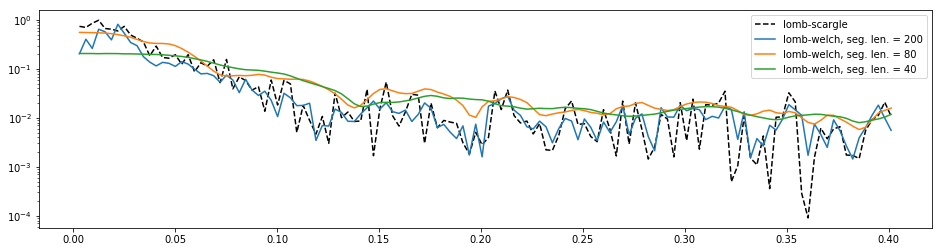

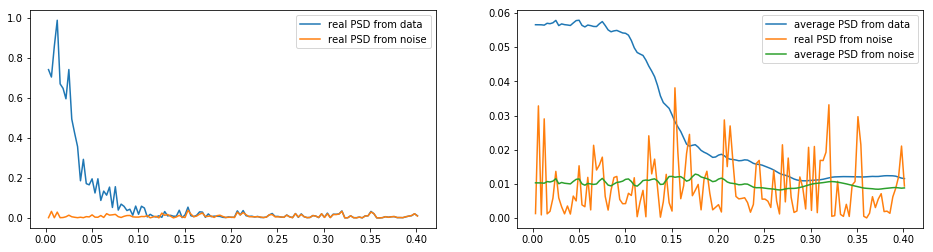

In [29]:
norm='psd'
weighted = True
windowed = False

# psd
real_psd = freqs.lomb_scargle(times, data, norm=norm, 
                              windowed=windowed, weighted=weighted)
real_psd0 = freqs.lomb_scargle(times, noise, norm=norm, 
                               windowed=windowed, weighted=weighted)


fig = plt.figure(figsize=(16, 4))
plt.semilogy(freqs, real_psd, 'k--', label='lomb-scargle')
for i in [2, 5, 10]:
    plt.semilogy(freqs, freqs.lomb_welch(times, data, len(data)//i, 0.5, 
                                         norm=norm, weighted=weighted, 
                                         windowed=windowed), 
             label='lomb-welch, seg. len. = {}'.format(len(data)//i))
plt.legend()

avg_psd = freqs.lomb_welch(times, data, len(data)//20, 0.5, 
                           norm=norm, weighted=weighted, windowed=windowed)
avg_psd0 = freqs.lomb_welch(times, noise, len(data)//20, 0.5, 
                            norm=norm, weighted=weighted, windowed=windowed)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(freqs, real_psd, label='real PSD from data')
ax1.plot(freqs, real_psd0, label='real PSD from noise')
ax1.legend()

ax2.plot(freqs, avg_psd, label='average PSD from data')
ax2.plot(freqs, real_psd0, label='real PSD from noise')
ax2.plot(freqs, avg_psd0, label='average PSD from noise')
ax2.legend()

# for now we are going to simplify this and not use the PSD this is because the data are generated 
# with white gaussian noise
# avg_psd = None
# avg_psd0 = None


# avg_psd = avg_psd0
# avg_psd = np.sqrt(1/n)
# avg_psd0 = np.sqrt(1/n)
# print(np.sqrt(1/n))

Text(0,0.5,'SNR')

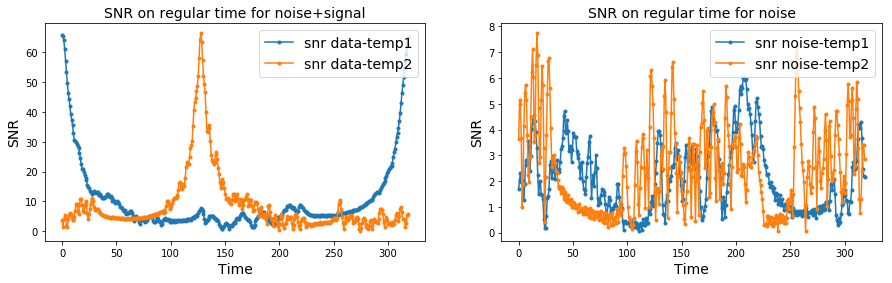

In [34]:
# snr
# use a regular time
snr_time = TimesSamples(n=n, delta=times.duration/len(times), struct="regular")
def snrs(snr_t, avg_psd=None, avg_psd_noise=None):

    snr1 = mfilter(snr_t, stilde, htilde1, reg, psd=avg_psd)
    snr2 = mfilter(snr_t, stilde, htilde2, reg, psd=avg_psd)
    snr01 = mfilter(snr_t, ntilde, htilde1, reg, psd=avg_psd)
    snr02 = mfilter(snr_t, ntilde, htilde2, reg, psd=avg_psd)
    return snr1, snr2, snr01, snr02


snr1, snr2, snr01, snr02 = snrs(snr_time, avg_psd=avg_psd, avg_psd_noise=avg_psd0)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
ax1.plot(snr_time, np.abs(snr1), '.-', label='snr data-temp1')
ax1.plot(snr_time, np.abs(snr2), '.-', label='snr data-temp2')
ax1.legend(fontsize=14)
ax1.set_title("SNR on regular time for noise+signal", fontsize=14)
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("SNR", fontsize=14)
ax2.plot(snr_time, np.abs(snr01), '.-', label='snr noise-temp1')
ax2.plot(snr_time, np.abs(snr02), '.-', label='snr noise-temp2')
ax2.legend(fontsize=14)
ax2.set_title("SNR on regular time for noise", fontsize=14)
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("SNR", fontsize=14)

Text(0,0.5,'SNR')

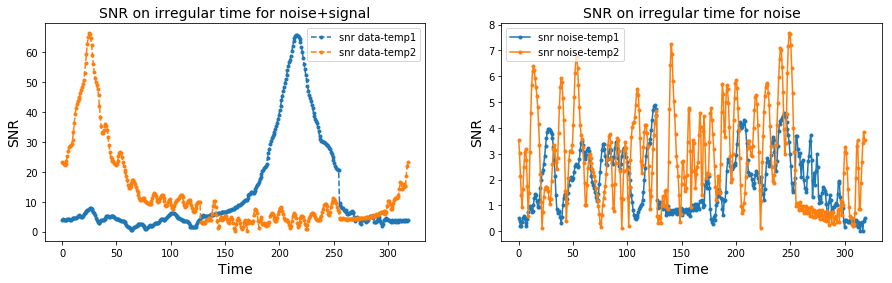

In [35]:
snr1, snr2, snr01, snr02 = snrs(times, avg_psd=avg_psd, avg_psd_noise=avg_psd0)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
ax1.plot(snr_time, np.abs(snr1), '.--', label='snr data-temp1')
ax1.plot(snr_time, np.abs(snr2), '.--', label='snr data-temp2')
ax1.legend()
ax1.set_title("SNR on irregular time for noise+signal", fontsize=14)
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("SNR", fontsize=14)

ax2.plot(snr_time, np.abs(snr01), '.-', label='snr noise-temp1')
ax2.plot(snr_time, np.abs(snr02), '.-', label='snr noise-temp2')
ax2.legend()
ax2.set_title("SNR on irregular time for noise", fontsize=14)
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("SNR", fontsize=14)

13.30742822799018 13.30742822799018


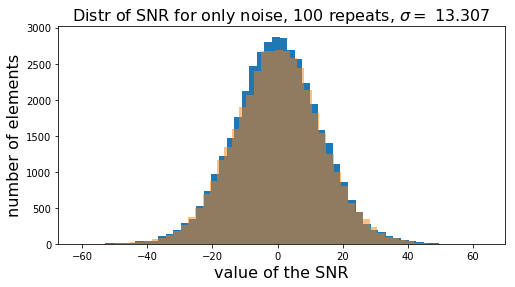

In [36]:
# _ = plt.hist(np.append(snr01.real, snr02.real), bins=50)
# _ = plt.hist(np.append(snr01.imag, snr02.imag), bins=50)
# print(np.std(snr01.real), np.std(snr01.imag))

snr_noise_real = []
snr_noise_imag = []
N_repeat = 100
for i in range(N_repeat):
    data_aux = TimeSeries(np.random.normal(0, noise_level, n), times=times)
    reg.reset()
    stilde_aux = data_aux.to_frequencyseries(reg=reg)
    
    psd_aux = freqs.lomb_welch(times, data_aux, len(data_aux)//10, 0.5, 
                              norm=norm, windowed=windowed, weighted=weighted)
#     psd_aux = None

    snr_aux = mfilter(snr_time, stilde_aux, htilde1, reg, psd=psd_aux)
    snr_noise_real.extend(snr_aux.real)
    snr_noise_imag.extend(snr_aux.imag)
    
plt.figure(figsize=(8,4))
plt.hist(snr_noise_real, bins=50)
plt.hist(snr_noise_imag, bins=50, alpha=0.5)
plt.title(r"Distr of SNR for only noise, {} repeats, $\sigma = $ {}".format(N_repeat, round(np.std(snr_noise_real), 3)), 
          fontsize=16)
plt.xlabel("value of the SNR", fontsize=16)
plt.ylabel("number of elements", fontsize=16)
# plt.savefig("hist_dist.png")
print(np.std(snr_noise_real), np.std(snr_noise_imag))


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.8107931175944357 0.8107931175944357


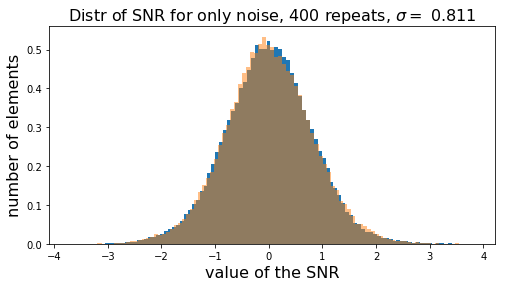

In [7]:
plt.figure(figsize=(8,4))
plt.hist(snr_noise_real, bins=100, normed=True)
plt.hist(snr_noise_imag, bins=100, alpha=0.5, normed=True)
plt.title(r"Distr of SNR for only noise, {} repeats, $\sigma = $ {}".format(N_repeat, round(np.std(snr_noise_real), 3)), 
          fontsize=16)
plt.xlabel("value of the SNR", fontsize=16)
plt.ylabel("number of elements", fontsize=16)
# plt.savefig("hist_dist.png")
print(np.std(snr_noise_real), np.std(snr_noise_imag))

In [8]:
# # define times and plot
# delta_t = 0.4
# n = 200
# struct = "automix"
# times = TimesSamples(initial_array=None, n=n, delta=delta_t, struct=struct)

# # delta_t = 1.3
# # Fs = 1 / delta_t
# # n = 128 * 4
# # times = TimesSamples(initial_array=np.arange(tsamples) * delta_t)

# def eval(U0, t0, tE, fs, times):
#     """Evaluate microlens event at given time array, return magnitude difference"""
#     u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
#     A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
#     dm = - 2.5 * np.log10(fs*(A - 1) + 1)
#     return dm

# dwindow = signal.tukey(n, alpha=1./8)
# dwindow = None
# noise_level = 0.1

# ## micro lens.
# t0 = min(times) + times.duration/2
# tE = 0.8 
# U0 = 3 #1.3 
# fs = 24 #16.9
# val = eval(U0, times[n//5], tE, fs, times)

# noise_data = np.random.normal(0, noise_level, n)
# data = val + noise_data

# val = eval(U0, t0, tE, fs, times)

# tE = 0.5
# U0 = 2.8
# fs = 23
# val2 = eval(U0, t0, tE, fs, times)

# ## simple sin
# # val = np.sin(2 * np.pi * 0.1 * times)
# # val2 = np.sin(2 * np.pi * 0.05 * times)
# # noise_data = np.random.normal(0, noise_level, n)
# # data = val + noise_data

# val = TimeSeries(val, times=times)
# val2 = TimeSeries(val2, times=times)
# # np.random.seed(2345)
# data0 = TimeSeries(noise_data, times=times)
# data = TimeSeries(data, times=times)

# # define freq. grid
# nyq = 1 / (2 * delta_t)
# samples_per_peak = 5
# df = 1 / times.duration / samples_per_peak
# freqs = FrequencySamples(input_time=times,
#                         minimum_frequency=df,
#                         maximum_frequency=nyq,
#                         samples_per_peak=samples_per_peak)
# gamma = 2 * len(freqs) / len(times)
# gamma = 1
# F = Dictionary(times, freqs)
# reg = RidgeRegression(alpha=10**(-6), phi=F)
# reg = LassoRegression(alpha=10**(-3), phi=F)
# reg = SGDRegression(alpha=10**(-4), max_iter=100, phi=F)

# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 4))
# ax1.plot(times, val, 'k--', label="temp1")
# ax1.plot(times, val2, 'b-o', label="temp2")
# ax1.plot(times, data0, 'r-x', alpha=0.5, label="only noise data")
# ax1.plot(times, data, 'g-.', alpha=0.6, label="data with signal")
# ax1.legend(fontsize=12)
# ax1.set_title("TimeSeries", fontsize=17)
# ax1.set_xlabel("time (sec)", fontsize=17)
# stilde = data.to_frequencyseries(reg=reg, window=dwindow)
# stilde *= gamma
# print("score for data", reg.score(data))
# reg.coef_ = np.zeros(len(reg.coef_))
# htilde1 = val.to_frequencyseries(reg=reg, window=dwindow)
# htilde1 *= gamma
# print("score for temp1", reg.score(val))
# reg.coef_ = np.zeros(len(reg.coef_))
# htilde2 = val2.to_frequencyseries(reg=reg, window=dwindow)
# htilde2 *= gamma
# print("score for temp2", reg.score(val2))
# reg.coef_ = np.zeros(len(reg.coef_))
# stilde0 = data0.to_frequencyseries(reg=reg, window=dwindow)
# stilde0 *= gamma
# print("score for data0", reg.score(data0))
# reg.coef_ = np.zeros(len(reg.coef_))

# ax2.plot(freqs, abs(htilde1), 'k--', label="temp1")
# ax2.plot(freqs, abs(htilde2), 'b-o', label="temp2")
# ax2.plot(freqs, abs(stilde0), 'r-x', label="only noise data")
# ax2.plot(freqs, abs(stilde), 'g-.', label="data with signal")
# ax2.legend(fontsize=12)
# ax2.set_title("frequencySeries", fontsize=17)
# ax2.set_xlabel("Frequency (Hz)", fontsize=17)
# plt.tight_layout()
# plt.savefig("timeseries_example.png", dpi=300)
# print(freqs[0], abs(htilde1[0]))
# print(freqs[0], abs(stilde[0]))

# # here we see that regression somehow produce always 0 output on regression, i.e., always found 0 value in
# # frequency domain at frequency 0, we could try to avoid this problem by not taking the 0 frequency
# print(min(times), max(times), np.mean(times), np.median(times))

In [9]:
# # here we donw have method for estimate noise psd yet, so we are going to use directly the psd of noise
# psd = data.psd(freqs)
# psd0 = data0.psd(freqs)
# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
# ax1.plot(freqs, psd, 'o--', label="PSD of data")
# ax1.plot(freqs, psd0, 'go--', label="PSD of noise")
# ax1.set_title("direct PSD with lomb-scarble", fontsize=17)
# ax1.legend(fontsize=14)

# # here we see that psd here and on pyCBC are quite similar expect for the "peaks" present here because this is 
# # not an average PSD (welch it is). We see from the pyCBC PSD that noise PSD has values between 0 and 0.5 
# #(checked visualy), here we see some values over 0.1 but the mayority under 0.1 and almos under 0.5, we could try 
# # to do a simples averagle over same interval duration

# def average_psd(segment_duration, oversampling_rate, timeSeries, freqs):
#     N = timeSeries.duration / segment_duration
#     n_seg = (int(N) - 1) / (1-oversampling_rate)
# #     print(n_seg)
#     t = 0
#     psd = FrequencySeries(np.zeros(len(freqs)), frequency_grid=freqs, epoch=timeSeries.epoch)
#     counter = 0
#     while t < timeSeries.duration - segment_duration:
#         aux_timeseries = timeSeries.get_time_slice(t, t+segment_duration)
#         window = signal.windows.hann(len(aux_timeseries))
#         aux_timeseries *= window
#         W = (window ** 2).sum() / len(window)
#         W = 1
#         psd += (aux_timeseries.psd(freqs) / W)
#         t += (1-oversampling_rate) * segment_duration
#         counter += 1
# #     print("counter is: ", counter)
#     aux_timeseries = timeSeries.get_time_slice(timeSeries.duration - segment_duration, timeSeries.duration)
#     window = signal.windows.hann(len(aux_timeseries))
#     aux_timeseries *= window
#     W = (window ** 2).sum() / len(window)
#     W = 1
#     psd += (aux_timeseries.psd(freqs) / W)
#     psd /= (counter+1)
    
#     return psd

# def average_psd_n(segment_n, oversampling_rate, timeSeries, freqs):
#     psd = FrequencySeries(np.zeros(len(freqs)), frequency_grid=freqs, epoch=timeSeries.epoch)
#     times = timeSeries.times
#     counter = 0
#     n = 0
#     while n < len(timeSeries) - segment_n:
#         aux_timeseries = timeSeries.get_time_slice(times[n], times[n + segment_n])
#         window = signal.windows.tukey(len(aux_timeseries), alpha=1./8)
#         aux_timeseries *= window
#         W = (window ** 2).sum() / len(window)
#         psd += (aux_timeseries.psd(freqs) / W)
#         n += segment_n
#         counter += 1
        
#     aux_timeseries = timeSeries.get_time_slice(times[len(times) - segment_n - 1], times[len(times)-1])
#     window = signal.windows.tukey(len(aux_timeseries), alpha=1./8)
#     aux_timeseries *= window
#     W = (window ** 2).sum() / len(window)
#     psd += (aux_timeseries.psd(freqs) / W)
#     counter += 1
#     psd /= counter
#     return psd
    
# seg_n = len(data)//10
# # seg_dur = 9
# # avg_psd = average_psd_n(seg_n, 0.5, data, freqs)
# # avg_psd = average_psd(seg_dur, 0.5, TimeSeries(noise_data, times=times), freqs)
# # avg_psd0 = average_psd_n(seg_n, 0.5, data0, freqs)
# avg_psd = freqs.lomb_welch(times, data, len(data)//20, 0.5)
# avg_psd0 = freqs.lomb_welch(times, data0, len(data)//20, 0.5)
# # print(avg_psd.value < 0)
# # for i in range(len(avg_psd)):
# #     if avg_psd.value[i] <= 0:
# #         print("ha")
# #         avg_psd[i] = 0.00001
# # print(avg_psd.value < 0)
# ax2.plot(freqs, avg_psd, "o--", label="PSD of data")
# ax2.plot(freqs, psd0, 'go--', label="PSD of noise")
# ax2.set_title("Averagin Lomg-Scargle PSD",fontsize=17)
# ax2.legend(fontsize=14)
# ax1.set_xlabel("frequency (Hz)", fontsize=17)
# ax2.set_xlabel("frequency (Hz)", fontsize=17)
# # ax1.set_ylim(0, 0.1)
# plt.tight_layout()
# plt.savefig("psd_aver.png")

# psd = avg_psd
# psd0 = avg_psd0

In [10]:
# snr = matched_filter(htilde1, stilde, psd=psd, reg=reg, times=times)
# snr2 = matched_filter(htilde2, stilde, psd=psd, reg=reg, times=times)

# snr0 = matched_filter(htilde1, stilde0, psd=psd0, reg=reg, times=times)
# snr02 = matched_filter(htilde2, stilde0, psd=psd0, reg=reg, times=times)

# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=True)
# ax1.plot(times, snr.real, 'r', label="data with temp1")
# ax1.plot(times, snr2.real, label="data with temp2")

# ax1.legend(fontsize=12)
# ax1.set_title("SNR", fontsize=17)

# ax2.plot(times - times[n//2], (np.roll(snr0, n//2)).real, 'r', label="noise with temp1")
# ax2.plot(times - times[n//2], (np.roll(snr02, n//2)).real, label="noise with temp2")
# ax2.legend(fontsize=12)
# plt.tight_layout()
# plt.savefig("snr_example.png")

In [11]:
# valoues = []
# window = signal.tukey(n, alpha=1./8)
# window = None
# for i in range(100):
#     data_aux = TimeSeries(np.random.normal(0, noise_level, n), times=times)
#     reg.coef_ = np.zeros(len(reg.coef_))
#     stilde_aux = data_aux.to_frequencyseries(reg=reg, window=window)
    
# #     psd_aux = data_aux.psd(freqs)
#     psd_aux = freqs.lomb_welch(times, data_aux, len(data_aux)//10, 0.5)
# #     psd_aux = None
    
#     snr_aux = matched_filter(htilde1, stilde_aux, psd=psd_aux, reg=reg, times=times)
#     valoues.extend(snr_aux.real)

# plt.figure(figsize=(8,4))
# plt.hist(valoues, bins=50)
# plt.title(r"Distr of SNR for only noise, 100 repeats, $\sigma = $ {}".format(round(np.std(valoues), 3)), 
#           fontsize=16)
# plt.xlabel("value of the SNR", fontsize=16)
# plt.ylabel("number of elements", fontsize=16)
# plt.savefig("hist_dist.png")
# print(np.std(valoues))

In [12]:
# using the chi statistic

def power_chisq(htilde, stilde, num_bins, psd, reg, times):
    
    bins = power_chisq_bins(htilde, num_bins, psd)
    
    
    snr, corr, norm = matched_filter_core(htilde, stilde, psd=psd, reg=reg, times=times)
    
    return power_chisq_from_precomputed(corr, snr, norm, bins, reg), len(bins)

def power_chisq_bins(htilde, num_bins, psd):
    sigma_vec = sigmasq_series(htilde, psd)
    return power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins)

def sigmasq_series(htilde, psd):
    autocorr = htilde.conj() * htilde / psd
    return autocorr.cumsum()

def power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins):
    sigmasq = sigma_vec[len(sigma_vec)-2]
    edge_vec = np.arange(0, num_bins) * sigmasq / num_bins
    bins = np.searchsorted(sigma_vec, edge_vec, side='right')
    bins = np.append(bins, len(sigma_vec) - 1)
    bins = np.unique(bins)
    if len(bins) != num_bins + 1:
        print("using {} bins instead of {}".format(len(bins), num_bins))
    return bins

def power_chisq_from_precomputed(corr, snr, norm, bins, reg):
    qtilde = FrequencySeries(np.zeros(len(corr)), frequency_grid=corr.frequency_object, dtype=corr.dtype,
                            epoch=corr.epoch)
    chisq = TimeSeries(np.zeros(len(snr)), times=snr.times, dtype=snr.dtype, epoch=snr.epoch)
    num_bins = len(bins) - 1
    
    for j in range(num_bins):
        k_min = int(bins[j])
        k_max = int(bins[j+1])
        qtilde[k_min:k_max] = corr[k_min:k_max]
        q = qtilde.to_timeseries(reg=reg)
        qtilde.fill(0)
        chisq += q.squared_norm()
        
    chisq = (chisq * num_bins - snr.squared_norm()) * (norm ** 2)
    chisq = TimeSeries(chisq, times=snr.times, epoch=snr.epoch)
    return chisq
    



In [13]:
# divs = 40
# chsq, n_bins = power_chisq(htilde1, stilde, divs, psd, reg, times)
# chsq /= (n_bins * 2) - 2
# chsq2, n_bins = power_chisq(htilde2, stilde, divs, psd, reg, times)
# chsq2 /= (n_bins * 2) - 2
# chsq0, n_bins = power_chisq(htilde1, stilde0, divs, psd0, reg, times)
# chsq0 /= (n_bins * 2) - 2
# chsq02, n_bins = power_chisq(htilde2, stilde0, divs, psd0, reg, times)
# chsq02 /= (n_bins * 2) - 2

In [14]:
# plt.plot(times - times[n//2], np.roll(chsq.real, n//2), 'r', label="data with temp1")
# plt.plot(times - times[n//2], np.roll(chsq2.real, n//2), label="data with temp2")
# plt.title("chi-square veto")
# plt.legend()
# plt.figure()
# plt.plot(times - times[n//2], np.roll(chsq0.real, n//2), 'r', label="noise with temp1")
# plt.plot(times - times[n//2], np.roll(chsq02.real, n//2), label="noise with temp2")
# plt.legend()

In [15]:
# def weighted_snr(snr, chisq):
#     for i in range(len(chisq)):
#         if chisq[i] > 1:
#             snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
        
#     return snr

In [16]:
# w_snr = weighted_snr(snr, chsq)
# w_snr2 = weighted_snr(snr2, chsq2)

# w_snr0 = weighted_snr(snr0, chsq0)
# w_snr02 = weighted_snr(snr02, chsq02)

In [17]:
# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=True)

# ax1.plot(times - times[n//2], (np.roll(w_snr, n//2)).real, 'r', label="data with temp1")
# ax1.plot(times - times[n//2], (np.roll(w_snr2, n//2)).real, label="data with temp2")

# ax2.plot(times - times[n//2], (np.roll(w_snr0, n//2)).real, 'r', label="noise with temp1")
# ax2.plot(times - times[n//2], (np.roll(w_snr02, n//2)).real, label="noise with temp2")
# ax1.legend()
# ax1.set_title("SNR after chi-square veto")
# ax2.legend()

In [18]:
# t0 = min(times) + times.duration/2
# tE = 0.8 
# U0 = 3 #1.3 
# fs = 24 #16.9
# val_fit = eval(U0, t0 - times[np.argmax(w_snr)], tE, fs, times)
# print(times[np.argmax(w_snr)])
# tE = 0.5
# U0 = 2.8
# fs = 23
# val2_fit = eval(U0, t0 - times[np.argmax(w_snr2)], tE, fs, times)

# plt.figure(figsize=(8,4))
# plt.plot(times, val_fit, 'bo-', label="matched with temp. 1")
# plt.plot(times, val2_fit, 'rx-', label="matched with temp. 2")
# plt.plot(times, data, 'k', alpha=0.5, label="data")
# plt.title("matched template for the data",fontsize=16)
# plt.xlabel("time (sec)",fontsize=16)
# plt.legend(fontsize=13)
# plt.savefig("matched_data.png", dpi=300)